In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import os
sys.path.append('/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data')
os.chdir('/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data')

In [3]:
df=pd.read_csv('data.csv',encoding='latin1')
df.columns=[i.lower() for i in pd.read_csv('data.csv',nrows=0).columns]

# df.loc[:,'invoicedate']=pd.to_datetime(df.invoicedate)

# df.loc[:,'year_month']=df.invoicedate.dt.to_period('M')
# df.loc[:,'week']=df.invoicedate.dt.to_period('W')

display(df.head(2))
df.shape

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)

In [ ]:
def generate_dt_periods(data,date_col_str='invoicedate',
                        label='weekly',frequency='W'):
  df=data.copy()
  if not (np.issubdtype(df.loc[:,date_col_str], np.datetime64)):
    df.loc[:,date_col_str]=pd.to_datetime(df.loc[:,date_col_str])
  
  df.loc[:,label]=df.invoicedate.dt.to_period(frequency)
  return df

df=generate_dt_periods(data=df)
df=generate_dt_periods(data=df,date_col_str='invoicedate',
                        label='daily',frequency='D')
df=generate_dt_periods(data=df,date_col_str='invoicedate',
                        label='hourly',frequency='H')
df=generate_dt_periods(data=df,date_col_str='invoicedate',
                        label='year_month',frequency='M')

## Demand based selection

In [ ]:
df[['daily','hourly','weekly','year_month']].nunique()#,150 -- 100,50; 30--> 20,10,-->13--5,3

daily          305
hourly        2938
weekly          53
year_month      13
dtype: int64

In [ ]:
df.loc[:,'quantity']=df.loc[:,'quantity'].abs()
df.loc[:,'unitprice']=df.loc[:,'unitprice'].apply(lambda x: max(0,x))

# grp_cols=['description','year_month']
# grp_cols=['description','weekly']
grp_cols=['description','daily']
# grp_cols=['description','hourly']

df_q=df.groupby(grp_cols)[['quantity']].sum().unstack()['quantity']
df_q=df.groupby(['description',
                 pd.Grouper(key='invoicedate',freq='7D')])[['quantity']].sum().unstack()['quantity']
df_q.loc[:,'ct_q']=df_q.notna().sum(axis=1)

df_q.loc[:,'sum_q']=df_q.sum(axis=1)
# df_q.sort_values(by=['ct_q','sum_q'],ascending=False) # We wil try to analyse those producst that have demand across all months

In [ ]:
len(df_q.columns)

56

In [ ]:
# df_quantity_final=df_q[df_q.ct_q==df['year_month'].nunique()]#There are 1209 products that have sold for all the months over an year time
df_quantity_final=df_q[df_q.ct_q==(len(df_q.columns)-2)]
t50_quantityBasedProducts=list(df_quantity_final.sort_values('sum_q',ascending=False)[:20].index)

# df_quantity_final=df_q.copy()
# t50_quantityBasedProducts=list(df_q.sort_values(by=['ct_q','sum_q'],ascending=False)[:20].index)
# t50_quantityBasedProducts

## PRice based selection

In [ ]:
# df_p=df.groupby(grp_cols)[['unitprice']].mean().unstack()['unitprice']
df_p=df.groupby(['description',
                 pd.Grouper(key='invoicedate',freq='7D')])[['unitprice']].mean().unstack()['unitprice']
df_p.loc[:,'ct_price']=df_p.notna().sum(axis=1)

df_p.loc[:,'mean_price']=df_p.mean(axis=1)


df_p.sort_values(by=['ct_price','mean_price'],ascending=False) # We wil try to analyse those products which has average price across all the year
len(df_p.columns)


56

In [ ]:
df_price_final=df_p[df_p.ct_price==(len(df_p.columns)-2)]
df_price_final.shape
t50_priceBasedProducts=list(df_price_final.sort_values('mean_price',ascending=False)[:10].index)
# df_price_final

# df_price_final=df_p.copy()
# t50_priceBasedProducts=list(df_price_final.sort_values('mean_price',ascending=False)[:10].index)


## SELECTION of top 100 products

In [ ]:
final_products=list(set(
                    t50_quantityBasedProducts+t50_priceBasedProducts
                    ))

final_products=[i for i in final_products if len(i.split())>=2]
print(len(final_products))
df_q_tbu=df_quantity_final.loc[final_products,[i for i in df_quantity_final.columns if '_q' not in str(i)]].T
df_p_tbu=df_price_final.loc[final_products,[i for i in df_price_final.columns if '_' not in str(i)]].T


27


In [ ]:
final_products=[i.capitalize().strip().replace(' ','_').lower() for i in final_products]
df_q_tbu.columns=[i.capitalize().strip().replace(' ','_').lower()+'__demand' for i in df_q_tbu.columns]
df_p_tbu.columns=[i.capitalize().strip().replace(' ','_').lower()+'__price' for i in df_p_tbu.columns]
df_tbu=df_q_tbu.merge(df_p_tbu,right_index=True,left_index=True)

# sorted(df_p_tbu.index)==sorted(df_q_tbu.index)

## PriceSensitivityAnalysis

In [ ]:
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import seaborn as sns

dict_betas=defaultdict(dict)
for temp_product in final_products:

  y_col=temp_product+'__demand'
  xx=df_tbu.drop([y_col],axis=1)
  xx=xx.loc[:,[i for i in xx.columns if '_price'in i ]]
  # xx=xx.fillna(xx.mean())
  # xx=xx[xx>0]
  # xx.dropna(axis=1,inplace=True)
  xx=np.log(xx)
  
  yy=np.log(df_tbu[y_col])
  yy=yy.fillna(yy.mean())
  yy=yy.loc[xx.index]

  lr=LinearRegression()
  lr.fit(xx,yy)

  temp_beta={i:j for i,j in zip(list(xx.columns),lr.coef_)}
  dict_betas[y_col]=temp_beta


df_priceSensitivity=pd.DataFrame(dict_betas).sort_values(by=y_col)#.loc['charlotte_bag_suki_design__price']


(27, 27)

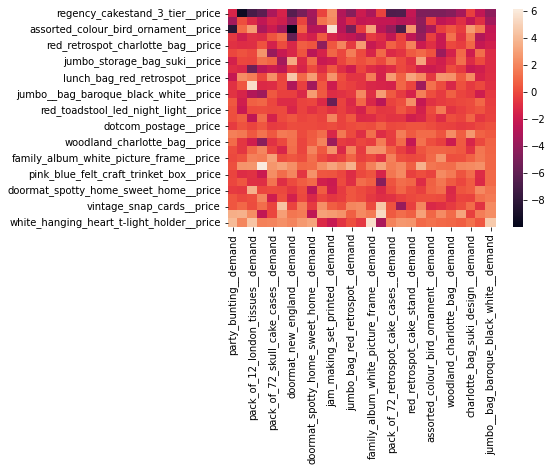

In [ ]:
sns.heatmap(df_priceSensitivity)
df_priceSensitivity.shape

In [ ]:
df_priceSensitivity=df_priceSensitivity.sort_index(axis=1).sort_index()#.shape
df_priceSensitivity=pd.DataFrame((df_priceSensitivity.values+df_priceSensitivity.T.values)/2,
columns=df_priceSensitivity.columns,index=df_priceSensitivity.index)# Depends on whether if A is substitue of B then B is substitute of A

In [ ]:
# dict_betas
df_priceSensitivity.shape



(27, 27)

### If price of substitute item goes up then the demand of product under consideraion will go up thus delat demand/delta price_sunstitute is positive

### We intend to find those products that have high degree of association with each other

### We will use pair-reciprocation based rule to delineate substitute goods,For the reason we will use average of betas generated using demand_a wrt price_b and the one generated using demand_b using price_a



In [ ]:
# df_priceSensitivity.T > 
df_priceSensitivity.T.apply(np.quantile,q=0.9,axis=1)

df_mask=df_priceSensitivity.T.apply(lambda x: (x>np.quantile(x,q=0.8)) & x>0
,axis=1)

In [ ]:
df_sub_weekly=df_mask.apply(lambda s : pd.Series(s[s==True].index),axis=1)#[0]

In [ ]:
# df_sub_weekly

# Product Consistency Analysis

In [6]:
########## Sampling of Price 
def generateSampleUnit(df,parent_col='description',
                       unit_col='unitprice',dt_col='invoicedate',frequency='7D'):
  if not (np.issubdtype(df.loc[:,dt_col], np.datetime64)):
    df.loc[:,dt_col]=pd.to_datetime(df.loc[:,dt_col])
  
  df_p=df.groupby([parent_col,
                  pd.Grouper(key=dt_col,freq=frequency)])[[unit_col]].mean().unstack()[unit_col]
  df_original=df_p.copy()
  
  df_p.loc[:,'ct_unit']=df_p.notna().sum(axis=1)

  df_p.loc[:,'mean_unit']=df_p.mean(axis=1)
  cols_added=[i for i in df_p.columns if i not in df_original.columns]

  return (df_p,cols_added)
############# RankGenerator
def rankGenerator(df_p,cols_tbu=['ct_price','mean_price']):
  temp_df=df_p.sort_values(by=cols_tbu,ascending=False)
  # temp_df.reset_index()
  temp_df.loc[:,'rk']=np.arange(temp_df.shape[0])+1
  return temp_df['rk']

# PRICE BAsed

In [7]:
lt_freq=list(reversed(['1D','3D','7D','15D','1M','3M','6M']))#Check rank consistency with increase in sampling frequency
f=lt_freq[0]
df_q_rk=pd.DataFrame(columns=lt_freq,index=df['description'].unique())


for f in lt_freq:
  df_p,cols_added=generateSampleUnit(df,parent_col='description',
                        unit_col='quantity',dt_col='invoicedate',frequency=f)
  df_q_rk.loc[:,f]=rankGenerator(df_p,cols_tbu=cols_added)

cols_added

['ct_unit', 'mean_unit']

In [ ]:
df_q_rk#.mean(axis=1).sort_values()[1:20]
df_q_rk.sort_values('7D')
df_q_rk.sort_values('1D')[:30]#1D resembles that the demand consistency is very frequent across all days and 6M tells primarily about price

,6M,3M,1M,15D,7D,3D,1D
WHITE HANGING HEART T-LIGHT HOLDER,214.0,193.0,137.0,82.0,25.0,4.0,1.0
JUMBO BAG RED RETROSPOT,155.0,117.0,79.0,47.0,12.0,3.0,2.0
REGENCY CAKESTAND 3 TIER,751.0,766.0,603.0,421.0,84.0,16.0,3.0
ASSORTED COLOUR BIRD ORNAMENT,127.0,104.0,64.0,42.0,8.0,2.0,4.0
PACK OF 72 RETROSPOT CAKE CASES,80.0,84.0,56.0,26.0,4.0,1.0,5.0
LUNCH BAG RED RETROSPOT,460.0,393.0,272.0,184.0,39.0,6.0,6.0
NATURAL SLATE HEART CHALKBOARD,878.0,781.0,511.0,393.0,71.0,15.0,7.0
PARTY BUNTING,651.0,569.0,388.0,266.0,53.0,12.0,8.0
JAM MAKING SET WITH JARS,898.0,786.0,548.0,370.0,74.0,33.0,9.0
RECIPE BOX PANTRY YELLOW DESIGN,954.0,817.0,551.0,390.0,72.0,34.0,10.0


## Quantity Based

In [ ]:
lt_freq=list(reversed(['1D','3D','7D','15D','1M','3M','6M']))#Check rank consistency with increase in sampling frequency
f=lt_freq[0]
df_p_rk=pd.DataFrame(columns=lt_freq,index=df['description'].unique())


for f in lt_freq:
  df_p,cols_added=generateSampleUnit(df,parent_col='description',
                        unit_col='unitprice',dt_col='invoicedate',frequency=f)
  df_p_rk.loc[:,f]=rankGenerator(df_p,cols_tbu=cols_added)

## p_val correction/filtering

In [ ]:
import statsmodels.api as sm

temp_product=final_products[1]

y_col=temp_product+'__demand'
xx=df_tbu.drop([y_col],axis=1)
xx=np.log(xx.loc[:,[i for i in xx.columns if '_price'in i ]])
yy=np.log(df_tbu[y_col])

lr=sm.OLS(yy,xx)

results=lr.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                        OLS Regression Results                                        
Dep. Variable:     pack_of_12_london_tissues__demand   R-squared (uncentered):                   0.987
Model:                                           OLS   Adj. R-squared (uncentered):              0.972
Method:                                Least Squares   F-statistic:                              67.88
Date:                               Sat, 23 Apr 2022   Prob (F-statistic):                    1.65e-17
Time:                                       22:33:54   Log-Likelihood:                         -53.470
No. Observations:                                 53   AIC:                                      162.9
Df Residuals:                                     25   BIC:                                      218.1
Df Model:                                         28                                                  
Covariance Type:                           nonrobust                     

# ROUGH WORK

In [ ]:
# # !mkdir '/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data'
# # !unzip '/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/archive.zip' -d '/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data/'
# # pd.read_csv('/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data/data.csv')
# import os
# import sys
# sys.path.append('/content/drive/MyDrive/Demand_Analytics/ProvisionalDataset/data')




In [ ]:
cols_tbu=[i.lower() for i in pd.read_csv('data.csv',nrows=0).columns]
# cols_tbu


In [ ]:
#Actually there is one particular row that is not delimited properly
#We intend to detremine that row but cannot read csv file in stream

### IGNORE Encoding latin mei thi


df=pd.DataFrame(columns=cols_tbu)
ii=0
increment_step=10000
stop_ii=6000000

# stop_date=pd.to_datetime('12/18/2010')
stop_date=pd.to_datetime('01/01/2011')

latest_date=pd.to_datetime('01/01/2010')

skipped_thousand=[]

# while ii<stop_ii:
while latest_date<= stop_date:
  # print(ii,latest_date)
  increment_step=min(500,increment_step)
  try:
    temp_df=pd.read_csv('data.csv',
                        skiprows=ii,nrows=increment_step,
                        header=None,encoding='latin1')
    temp_df.columns=cols_tbu
    temp_df.loc[:,'invoicedate']=pd.to_datetime(temp_df.invoicedate)

    df=pd.concat([df,temp_df])
    latest_date=df.invoicedate.max()

  except:
    skipped_thousand.append(ii)
    # increment_step+=500
    
    pass
  ii+=increment_step


 
df.reset_index(drop=True,inplace=True)
df.drop(0,inplace=True)

 

In [ ]:
len(skipped_thousand)
ii

42500

In [ ]:
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
1,536409,72802C,VANILLA SCENT CANDLE JEWELLED BOX,1,2010-12-01 11:45:00,4.25,17908.0,United Kingdom
2,536409,22109,FULL ENGLISH BREAKFAST PLATE,1,2010-12-01 11:45:00,3.75,17908.0,United Kingdom
3,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
4,536409,22531,MAGIC DRAWING SLATE CIRCUS PARADE,1,2010-12-01 11:45:00,0.42,17908.0,United Kingdom
5,536409,21811,CHRISTMAS HANGING HEART WITH BELL,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
41995,539993,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12,2011-01-04 10:00:00,2.95,13313.0,United Kingdom
41996,539993,22808,SET OF 6 T-LIGHTS EASTER CHICKS,12,2011-01-04 10:00:00,2.95,13313.0,United Kingdom
41997,539993,22458,CAST IRON HOOK GARDEN FORK,8,2011-01-04 10:00:00,2.55,13313.0,United Kingdom
41998,539993,22862,LOVE HEART NAPKIN BOX,4,2011-01-04 10:00:00,4.25,13313.0,United Kingdom


In [ ]:
pd.to_datetime(df.invoicedate).max()< pd.to_datetime('01/01/2011')

True

In [ ]:
df.invoicedatedt.month #< '01/01/2010'

AttributeError: ignored

In [ ]:
df=pd.read_csv('data.csv',nrows=30000)

df.columns=[i.lower() for i in df.columns]
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
29995,538839,21874,GIN AND TONIC MUG,1,12/14/2010 13:10,1.25,14606.0,United Kingdom
29996,538839,21934,SKULL SHOULDER BAG,2,12/14/2010 13:10,1.65,14606.0,United Kingdom
29997,538839,22299,PIG KEYRING WITH LIGHT & SOUND,1,12/14/2010 13:10,1.25,14606.0,United Kingdom
29998,538839,82486,WOOD S/3 CABINET ANT WHITE FINISH,1,12/14/2010 13:10,7.95,14606.0,United Kingdom


In [ ]:
df.description.str.lower().value_counts()

white hanging heart t-light holder     170
paper chain kit 50's christmas         148
regency cakestand 3 tier               121
red woolly hottie white heart.         119
hand warmer bird design                112
                                      ... 
chunky cracked glaze necklace ivory      1
fire polished glass bracelet black       1
4 gold flock christmas balls             1
green  diamante pen in gift box          1
jam jar with blue lid                    1
Name: description, Length: 2588, dtype: int64

In [ ]:
df.invoicedate#.max()

0             InvoiceDate
1          12/1/2010 8:26
2          12/1/2010 8:26
3          12/1/2010 8:26
4          12/1/2010 8:26
               ...       
29995    12/14/2010 13:10
29996    12/14/2010 13:10
29997    12/14/2010 13:10
29998    12/14/2010 13:10
29999    12/14/2010 13:10
Name: invoicedate, Length: 30000, dtype: object

In [ ]:
pd.read_csv('data.csv',
                        skiprows=11,nrows=100,
            header=None)

,0,1,2,3,4,5,6,7
0,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,12/1/2010 8:34,2.10,13047,United Kingdom
1,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,12/1/2010 8:34,2.10,13047,United Kingdom
2,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,12/1/2010 8:34,3.75,13047,United Kingdom
3,536367,22310,IVORY KNITTED MUG COSY,6,12/1/2010 8:34,1.65,13047,United Kingdom
4,536367,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,12/1/2010 8:34,4.25,13047,United Kingdom
...,...,...,...,...,...,...,...,...
95,536380,22961,JAM MAKING SET PRINTED,24,12/1/2010 9:41,1.45,17809,United Kingdom
96,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,12/1/2010 9:41,4.25,15311,United Kingdom
97,536381,84854,GIRLY PINK TOOL SET,5,12/1/2010 9:41,4.95,15311,United Kingdom
98,536381,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,12/1/2010 9:41,1.95,15311,United Kingdom


In [ ]:
# df=pd.DataFrame()
# for df_temp in pd.read_csv('data.csv',nrows=50000,chunksize=1000,iterator=True):
#   try:
#     df_temp.loc[:,'chunk']=ii
#     ii+=1
#     df=pd.concat([df,df_temp])
#   except:
#     pass

In [ ]:
df

""


In [ ]:
# pd.read_csv('data.csv',
#                         skiprows=50000,nrows=100,encoding='latin1',
#                         header=None)

df=pd.read_csv('data.csv', header=None,encoding='latin1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2,3,4,5,6,7
0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
3,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541906,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.1,12680.0,France
541907,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
df.stockcode.str.lower().value_counts()#.describe()
df.description.str.lower().value_counts()

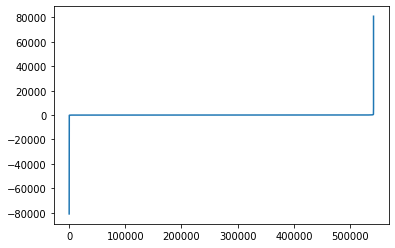

In [ ]:
# df.loc[:,'quantity'].sort_values().reset_index(drop=True).plot()
# df.loc[:,'unitprice'].abs()

In [ ]:
pd.DataFrame({
    'A':{'a':1,'b':2},
    'B':{'a':10,'b':20}
})

In [ ]:
from datetime import datetime
# (pd.to_datetime(df.loc[:,'invoicedate'])).dtype==
type(pd.to_datetime(datetime.now()))

# isinstance()

In [ ]:
xx.isna().sum()
yy.isna().sum()

# xx.describe().loc['min',:]#.max()
pd.concat([xx['jumbo_bag_red_retrospot__price'],df_tbu['jumbo_bag_red_retrospot__price']],axis=1).min()

jumbo_bag_red_retrospot__price   -inf
jumbo_bag_red_retrospot__price    0.0
dtype: float64

In [ ]:
df_tbu.fillna(df_tbu.mean(),inplace=True)
df_tbu[df_tbu>0].dropna(axis=0)
# df_tbu

,jumbo_bag_pink_vintage_paisley__demand,6_ribbons_rustic_charm__demand,party_bunting__demand,alarm_clock_bakelike_pink__demand,school_desk_and_chair__demand,lunch_bag_pink_polkadot__demand,adjust_bad_debt__demand,set/5_red_retrospot_lid_glass_bowls__demand,spaceboy_lunch_box__demand,pack_of_60_pink_paisley_cake_cases__demand,...,lunch_bag_woodland__price,cruk_commission__price,dotcom_postage__price,vintage_red_kitchen_cabinet__price,lunch_bag_spaceboy_design__price,decorative_hanging_shelving_unit__price,charlotte_bag_suki_design__price,amazon_fee__price,victorian_glass_hanging_t-light__price,jumbo__bag_baroque_black_white__price
daily,,,,,,,,,,,,,,,,,,,,,
2010-12-01,31.0,28.0,62.756757,37.0,1.571429,4.0,3.0,137.000000,27.0,122.0,...,1.650000,495.839375,588.630000,147.319444,1.650000,59.95,1.174000,6920.324048,1.880000,1.890000
2010-12-02,100.0,73.0,62.756757,4.0,1.571429,14.0,3.0,37.000000,101.0,144.0,...,1.650000,495.839375,353.002002,295.000000,1.650000,59.95,0.850000,6920.324048,1.250000,2.492650
2010-12-03,9.0,33.0,11.000000,46.0,1.571429,104.0,3.0,21.799296,16.0,133.0,...,2.844000,495.839375,440.370000,147.319444,2.503333,59.95,1.882500,6920.324048,2.510000,2.703333
2010-12-05,6.0,49.0,8.000000,17.0,1.571429,2.0,3.0,19.000000,56.0,10.0,...,1.650000,495.839375,353.002002,147.319444,1.650000,59.95,0.785000,6920.324048,1.648129,1.950000
2010-12-06,4.0,38.0,17.000000,7.0,1.571429,22.0,3.0,28.000000,28.0,56.0,...,2.503333,495.839375,918.533333,147.319444,2.747143,59.95,1.336000,6920.324048,2.006000,2.854000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,115.0,97.0,16.000000,16.0,1.571429,30.0,3.0,25.000000,180.0,57.0,...,2.476667,1100.440000,1585.452000,147.319444,2.642000,59.95,1.110000,14711.480000,2.108182,4.130000
2011-12-06,14.0,24.0,21.000000,62.0,1.571429,15.0,3.0,13.000000,78.0,26.0,...,1.650000,495.839375,736.380000,147.319444,2.312000,59.95,1.148750,6920.324048,2.035000,2.372857
2011-12-07,14.0,6.0,3.000000,40.0,1.571429,40.0,3.0,18.000000,4.0,55.0,...,2.063333,495.839375,1861.460000,147.319444,1.650000,59.95,0.806667,6920.324048,1.950000,2.490000


# Reference

In [ ]:
# https://www.kaggle.com/datasets/carrie1/ecommerce-data
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.to_period.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases